In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

This notebook is from a code along I did with Phil Tabor in the Udemy Course "Modern Reinforcement Learning: Deep Q Learning in PyTorch." Tabor shows how to code a Naive Deep Q Learning Agent that will fail due to the deadly triad. '
https://www.udemy.com/course/deep-q-learning-from-paper-to-code/

Use deep neural networks for large continous state spaces. Deep neural networks are universal function approximators. They can approximate almost any continuous function including action value function in Deep Q Learning.  

# Naive Deep Q Learning 

In [2]:
# this gives us access to the layers 
import torch.nn as nn 
# this gives us access to activation 
# functions like relu or sigmoid 
import torch.nn.functional as F 
# this gives us access to optimizers
import torch.optim as optim 
# the base package Torch gets imported as T
import torch as T

**Parametric models** for **Supervised Learning** seem very similar to ***Q-Learning Approximation Method.*** For Approximate Q Learning, the target is the Q function, and we only focused on the linear model for Reinforcement Learning so far. Is a non-linear model possible for Reinforcement Learning? In 2015, there was a breakthrough with a model called **Deep Reinforcement Learning.** 
<br>
### Problems: 
+ If you use a function approximator with a non-linear model, convergence is not guaranteed. Off-policy bootstrapped can be a problem.   
+ We can use bootstrapping to calculate the Q target value. Semi-gradient descent. This can cause a problem when we train the model because we don't actually have any gradient. This problem is also caused by bootstrapping. 
+ Another problem is that samples are highly correlated. 
<br> 
People call this the deadly triad. 

In [3]:
import gym
import numpy as np
# this gives us access to the layers 
import torch.nn as nn 
# this gives us access to activation 
# functions like relu or sigmoid 
import torch.nn.functional as F 
# this gives us access to optimizers
import torch.optim as optim 
# the base package Torch gets imported as T
import torch as T

## Pytorch Linear Classifier 
Pytorch classifier tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [4]:
# LinearClassifier that derives from nn.Module
# the reason that we derive PyTorch classes from nn.Module
# is because that gives us access to parameters of deep neural network
class LinearClassifier(nn.Module): 
    # takes learning rate, number of classes and input dimensions as input
    def __init__(self, alpha, num_classes, input_dims):
        # whenever we are deriving one class from another, 
        # we want to use the super constructor 
        """
        The super() function in Python makes class inheritance more manageable and extensible. The function returns a temporary object that allows reference to a parent class by the keyword super.
        The super() function has two major use cases:
        To avoid the usage of the super (parent) class explicitly.
        To enable multiple inheritances.
        https://www.educative.io/edpresso/what-is-super-in-python
        """
        super(LinearClassifier, self).__init__()
        # declare layers of deep neural network 
        # in this classifier, we have three linear layers 
        # first layer 
        #self.fcl = nn.Linear(*input_dims, 128)
        self.fc1 = nn.Linear(*input_dims, 128)
        # second layer
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, n_classes)
        # Adam is a type of stochastic gradient descent with momentum
        # it is an adaptive learning rate algorithm 
        # so it is highly useful for classifiers 
        # for the Deep Q Learning algorithm, the paper does opt for RMSprop optimizer
        # self.parameters() comes from nn.module and ells us wha we want to optimize 
        # the learning rate is the rate at which we want to optimize that quantity 
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        # for Deep Q Learning, we will want to use something like nn.MSELoss()
        
        self.loss = nn.CrossEntropyLoss() # typical loss function for multi-class classification problem
        # use GPU if it is available 
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        # send entire network to the device 
        self.to(self.device)
    
    # PyTorch handles backpropagation algorithm for us,
    # but we need to define own forward propagation algorithm
    def forward(self, data):
        # in our case the data is going to be screen images 
        # pass that data through first linear layer and activate it 
        # for Deep Q learning, we won't be using sigmoid function
        layer1 = F.sigmoid(self.fcl(data))
        # send activated output through second linear layer 
        # pass through linear layer first, then activate it 
        # order of operations from inner parentheses to outer parentheses 
        layer2 = F.sigmoid(self.fcl(layer1))
        # don't activate output of this layer
        # cross entropy loss will handle activation for us 
        layer3 = self.fcl(layer2)
        
        return layer3
    
    def learn(self, data, labels):
        # need to zero out gradiens for optimizer
        self.optimizer.zero_grad()
        # can't pass in numpy arrays as input, 
        # need to pass in tensors 
        data = T.tensor(data).to(self.device)
        # Pytorch also has a capital Tensor constructor
        # the lower case version preserves the type of the source data 
        # which is exactly what we want to do
        labels = T.tensor(labels).to(self.device)
        
        predictions = self.forward(data)
        # how far the predictions are from the actual labels 
        cost = self.loss(predictions, labels)
        # these next two functions are critical to the functionality 
        # of the learning loop
        # back propagate that cost
        cost.backward()
        # step the optimizer 
        self.optimizer.step()


Try using agent class, but separate game playing loop. 

In [5]:
# derives from nn.Module
# the reason that we derive PyTorch classes from nn.Module
# is because that gives us access to parameters of deep neural network
class LinearDeepQNetwork(nn.Module):
    # takes learning rate, actions, and input dimensions as input
    def __init__(self, lr, num_actions, input_dims):
        # whenever we are deriving one class from another, 
        # we want to use the super constructor 
        """
        The super() function in Python makes class inheritance more manageable and extensible. The function returns a temporary object that allows reference to a parent class by the keyword super.
        The super() function has two major use cases:
        To avoid the usage of the super (parent) class explicitly.
        To enable multiple inheritances.
        https://www.educative.io/edpresso/what-is-super-in-python
        """
        super(LinearDeepQNetwork, self).__init__()
        # declare layers of deep neural network 
        # in this classifier, we have three linear layers 
        # first layer, 128 neurons for fully connected layer 
        #self.fcl = nn.Linear(*input_dims, 128)
        self.fc1 = nn.Linear(*input_dims, 128)
        """
        second layer also linear, 128 neurons as input
        actions as output 
        second layer
        we have n_actions as output for this layer 
        because we want to calculate estimate for Q which is a state, action pair
        Q is a state, value action function, 
        we want to get out the value of each action for that state 
        dimensionality must correspond to number of actions for have for our environment 
        """
        self.fc2 = nn.Linear(128, num_actions)
        #self.fc3 = nn.Linear(256, n_classes)
        """
        Adam is a type of stochastic gradient descent with momentum
        it is an adaptive learning rate algorithm 
        so it is highly useful for classifiers 
        for the Deep Q Learning algorithm, the paper does opt for RMSprop optimizer
        self.parameters() comes from nn.module and ells us wha we want to optimize 
        the learning rate is the rate at which we want to optimize that quantity 
        """
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        # for Deep Q Learning, we will want to use something like nn.MSELoss()
        
        self.loss = nn.MSELoss() # typical loss function for multi-class classification problem
        # use GPU if it is available 
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        # send entire network to the device 
        self.to(self.device)
    # PyTorch handles backpropagation algorithm for us,
    # but we need to define own forward propagation algorithm
    def forward(self, state):
        # in our case the data is going to be screen images 
        # pass that data through first linear layer and activate it 
        # for Deep Q learning, we won't be using sigmoid function
        #layer1 = F.relu(self.fcl(state))
        layer1 = F.relu(self.fc1(state))
        # don't activate output of this layer
        # cross entropy loss will handle activation for us
        actions = self.fc2(layer1)
        return actions 
    

In [6]:
# this agent class is adapted from the class notebook 
#deterministic rule
# first choose random action
# monitor vc and vp while keep going to the same direction
# if the sign of the two velocities are different, flip the direction (action)
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Agent:
    def __init__(self, input_dims, num_actions, alpha, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_dec_rate=1e-5):
    #def __init__(self, input_dims, num_actions, alpha, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_dec_rate=1e-5):
            
        # save arguments as member variables of class
        self.alpha = alpha
        self.input_dims = input_dims
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon
        """
        It is important that epsilon decreases over time.
        The agent starts out doing a higher rate of exploration.
        As the agent learns more, the agent exploits high reward actions
        and decreass he rate of exploration. 
        """
        self.epsilon_dec_rate = epsilon_dec_rate
        self.epsilon_min = epsilon_min
        self.action_space = [*range(self.num_actions)]
        
        
        # an agent has a Q estimate, an agent is not a Q estimate
        # the Q estimate is one parameter of agent 
        # for choosing actions, decreasing epsilon, and learning from its experiences
        # Deep Q Network is in its own class, use as member variable for agent class
        self.Q = LinearDeepQNetwork(self.alpha, self.num_actions, self.input_dims)
        
       
    def select_action(self, observation): 
        # takes observation of environment as input 
        # we are using an epsilon greedy strategy to select actions
        # random.random() returns a number between 0.0 and 1.0 
        # https://stackoverflow.com/questions/33359740/random-number-between-0-and-1-in-python
        # if greater than epsilon, take greedy action
        if random.random() > self.epsilon:
            # make sure tha observation is Pytorch tensor 
            # that is sent to actual kuda device 
            # Pytorch is quite particular about datatypes of tensors passed in 
            # device is a property of the LinearDeepQNetwork
            # set dtype of float to be extra cautious about making sure everything matches up
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            # take argmax of tensor actions 
            # need to dereference it with a .item function
            # this is a nuance of the Pytorch framework,
            # when you feed forward state through the Q network,
            # you don't get back a numpy array, you get back a tensor
            # a tensor won't serve as appropriae input to OpenAI Gym's environment
            # the .item function gets the numpy array out of it 
            action = T.argmax(actions).item()
        # otherwise take a random action 
        else: 
            action = np.random.choice(self.action_space)
            
            
        return action
    
    def decay_epsilon(self):
        """
        TODO: look at other strategies for this 
        One source on Exploration/Exploitation Trade-off: 
        https://www.manifold.ai/exploration-vs-exploitation-in-reinforcement-learning
        References the Decaying Epsilon Greedy Algorithm 
        Review algorithm options
        needs to go to minimum value over time,
        that minimum value must be finite 
        """
        if self.epsilon > self.epsilon_min:
            # TODO: currently this is a linear dependence
            # you could also use a 1/square root dependence, or an exponential or logarithmic dependence
            # isn't really critical 
            # do need to make sure it reduces epsilon to min epsilon value over time 
            self.epsilon = self.epsilon*self.epsilon_dec_rate 
        else:
            self.epsilon = self.epsilon_min 
    
    def update_Qval(self, state, action, reward, successor_state):
        # first thing: zero gradients
        self.Q.optimizer.zero_grad()
        # we have numpy arrays, 
        # we need to convert them to Pytorch Kuda Tensors
        states = T.tensor(state, dtype=T.float).to(self.Q.device)
        actions = T.tensor(action)
        rewards = T.tensor(reward).to(self.Q.device)
        successor_state = T.tensor(successor_state, dtype=T.float).to(self.Q.device)
        
        # do feed forward to calculate update equation
        # we want the predicted values for the current state of the environment
        # we want the delta between the action the agent actually took,
        # and the maximum action it could have taken in that particular state
        # we want to move in the direction of the maximum action for a given state
        # distance between where we are and that target
        # take action indices from that Q predicted tensor 
        q_pred = self.Q.forward(states)[actions]
        # we want the maximum action for the agent's estimate of the resulting states
        q_next = self.Q.forward(successor_state).max()
        # reward times gamma plus maximum action in next state
        q_target = reward + self.gamma * q_next
        # difference between action the agent took and action agent could have taken 
        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        # backpropagate and step optimizer 
        loss.backward()
        self.Q.optimizer.step()
        self.decay_epsilon()


In [7]:
def plot_learning_curve(x, scores, epsilons):
    """
    create figure with two subplots
    one subplot will correspond to scores agent received
    other subplot corresponds to epsilons over time 
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)
    
    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")
    
    N=len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        # creating numpy array to keep track of scores from the previous 100 games 
        # for games 0 - 100, use current score 
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])
    
    ax2.scatter(x, running_avg, color="C1")
    # set_visible to False so we don't clutter up plot
    ax2.axes.get_xaxis().set_visible(False)
    # set ticks to the right side 
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color='C1')
    # label on the right side 
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors='C1')
    


episode  0 score 23.0 avg score 23.0 epsilon 0.01
episode  100 score 33.0 avg score 34.7 epsilon 0.01
episode  200 score 26.0 avg score 27.6 epsilon 0.01
episode  300 score 34.0 avg score 30.1 epsilon 0.01
episode  400 score 23.0 avg score 27.7 epsilon 0.01
episode  500 score 26.0 avg score 27.5 epsilon 0.01
episode  600 score 25.0 avg score 26.5 epsilon 0.01
episode  700 score 31.0 avg score 27.6 epsilon 0.01
episode  800 score 31.0 avg score 31.0 epsilon 0.01
episode  900 score 40.0 avg score 30.5 epsilon 0.01
episode  1000 score 26.0 avg score 30.2 epsilon 0.01
episode  1100 score 22.0 avg score 29.1 epsilon 0.01
episode  1200 score 23.0 avg score 29.0 epsilon 0.01
episode  1300 score 32.0 avg score 28.8 epsilon 0.01
episode  1400 score 29.0 avg score 25.4 epsilon 0.01
episode  1500 score 35.0 avg score 26.8 epsilon 0.01
episode  1600 score 32.0 avg score 28.8 epsilon 0.01
episode  1700 score 24.0 avg score 29.8 epsilon 0.01
episode  1800 score 41.0 avg score 34.5 epsilon 0.01
episo

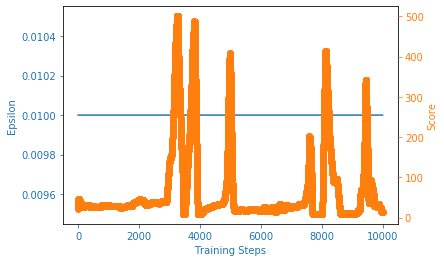

In [8]:
env = gym.make('CartPole-v1')
n_games = 10000
scores = []
eps_history = []

agent = Agent(alpha=0.0001, input_dims=env.observation_space.shape,
                  num_actions=env.action_space.n)

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()

    while not done:
        action = agent.select_action(obs)
        obs_, reward, done, info = env.step(action)
        score += reward
        agent.update_Qval(obs, action, reward, obs_)
        obs = obs_
    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.1f avg score %.1f epsilon %.2f' %
                (score, avg_score, agent.epsilon))
# plot out the learning curve 
# index games on the x axis from 1 
# makes more sense to play first game than 0th game
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history)

The epsilon decreases over time as you would expect until it reaches its first peak. Then something mysterious happens. After reaching the peak, it catastrophically drops back down to its first minimum. This occurs several times. Our naive implementation of Deep Q Learning Agent as applied to a continuous state space simply does not work. 
Problems with this approach:
+ Agent only learns from one example: the agent takes thousands of steps and this experience is effectively discarded each time 
+ Enormous parameter space: Neural network is a function approximator 
+ Large epsilon enables exploration: every time we start an episode, we start from a random point in that enormous parameter space. We jump around that space quite easily when the epsilon is large. Max actions tend to favor parts of the space that look familiar. As we gradually reduce epsilon, jumps become smaller. This makes getting caught in a local minimum more likely. This explains why our score drops off when epsilon goes to 0.01. 
+ We are using one network for two tasks: the same network is used to evaluate the maximum action and to choose that maximum action. This gets updated at every step so we are really chasing a moving target. 
+ That max has potential to **bias** our agent. We are always evaluating with respect to the max so this is the very definition of bias. 
+ Could it learn with more games? Perhaps. But it might be very costly. Cartpole is just a vector of four elements. Games like Atari have far more dimensions. 

The Naive Implementation didn't work out. Took input vector from the environment as input. Passed it through linear layers as input. Used simple state representations of our environment. It won't always be possible to do this. We are going to switch from observation vectors to more complex observations of the environment. To use screen images, we are going to need to use **convolutions**. A convolution is a matrix product that **performs feature extraction.** The features extracted tend to be unrecognizable to us as humans. 
<br> A convolution is formed by sliding a smaller matrix, a **filter**, over a larger matrix, the **input image** and taking the matrix product each time. The size of the filter is called the **kernel.** The **stride** is how much space it skips each time it slides. The resulting numbers are then stored as a new matrix that is smaller than the original matrix. In reality, we will use a number of filters. For example, if we use 32 filters, the 32 filters will be rastered over the image resulting in 32 smaller matrices. The output of the convolutions are **activated**, typically wih the **relu function.** The smaller activated matrices serve as input for regular linear layers. 

## Deep Q Learning 
DeepQ Network was developed by DeepMind in 2015. The function approximator is a Deep Convolutional Neural Network. A Deep Convolutional Neural Network is highly non-linear so it works well but isn't guaranteed to converge. This algorithm required some clever tricks to work. 

### Problem 1: Samples are correlated 
They solved this by using **replay buffers.** Randomly sample in different order. Then use gradient descent. Then samples are no longer correlated. 

### Problem 2: Moving Target Q Value so Regression Target is not Stable 
Separate target network from prediction network. 

Note: the information in this notebook is from Geena Kim's Fall 2012 Deep Q Learning Lecturs for the University of Colorado 3202 AI Course. 